# Time Series Forecasting With Prophet & NeuralProphet in Python
Time series forecasting can be challenging as there are many different methods you could use and many different hyperparameters for each method.

The Prophet library is an open-source library designed for making forecasts for univariate time series datasets. It is easy to use and designed to automatically find a good set of hyperparameters for the model in an effort to make skillful forecasts for data with trends and seasonal structure by default.

Prophet implements what they refer to as an additive time series forecasting model, and the implementation supports trends, seasonality, and holidays.

Implements a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects.

## Install FB Prophet & Neural Prophet and Yahoo Financials and import the necessary libraries

In [ ]:
!pip install neuralprophet[live]
!pip install fbprophet
!pip install plotly
!pip install yfinance # Install data from Yahoo
!pip install yahoofinancials # Install financials from Yahoo
# !pip install jupyter-dash # for installing dash on Jupyter NB

     |████████████████████████████████| 61kB 5.1MB/s 
     |████████████████████████████████| 81kB 6.8MB/s 
     |████████████████████████████████| 748.8MB 28kB/s 
ERROR: torchvision 0.10.0+cu102 has requirement torch==1.9.0, but you'll have torch 1.6.0 which is incompatible.
ERROR: torchtext 0.10.0 has requirement torch==1.9.0, but you'll have torch 1.6.0 which is incompatible.
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1
  Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102
     |████████████████████████████████| 6.3MB 21.0MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.60-py2.py3-none-any.whl size=23819 sha256=9526628b9e8f4879c8c9f18164419478f3564a3adb3ae1ff36e8b24fe2f20481
  Stored in directory: /root/.cache/pip/wheels/f0/be/a4/846f02c5985562250917b0ab7b33fff737c8e6e8cd5209aa3b
Successfully built yfinance
  Found existing i

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot

#Libraries for Statistical Models
import statsmodels.api as sm

from fbprophet import Prophet
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.plot import plot_plotly, plot_components_plotly
import base64

from neuralprophet import NeuralProphet

# The variability of results comes from stochastic gradient descent (SGD) finding different optima on different runs. The majority of the randomness comes from the random initialization of weights, 
# different learning rates and different shuffling of the dataloader. We can control the random number generator by setting it's seed。
from neuralprophet import set_random_seed
import datetime

import yfinance as yf
from yahoofinancials import YahooFinancials

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Importing and processing data from source

[*********************100%***********************]  1 of 1 completed


Text(0.5, 1.0, 'USDAUD Prices From 2000.1.1 to 2021.6.30')

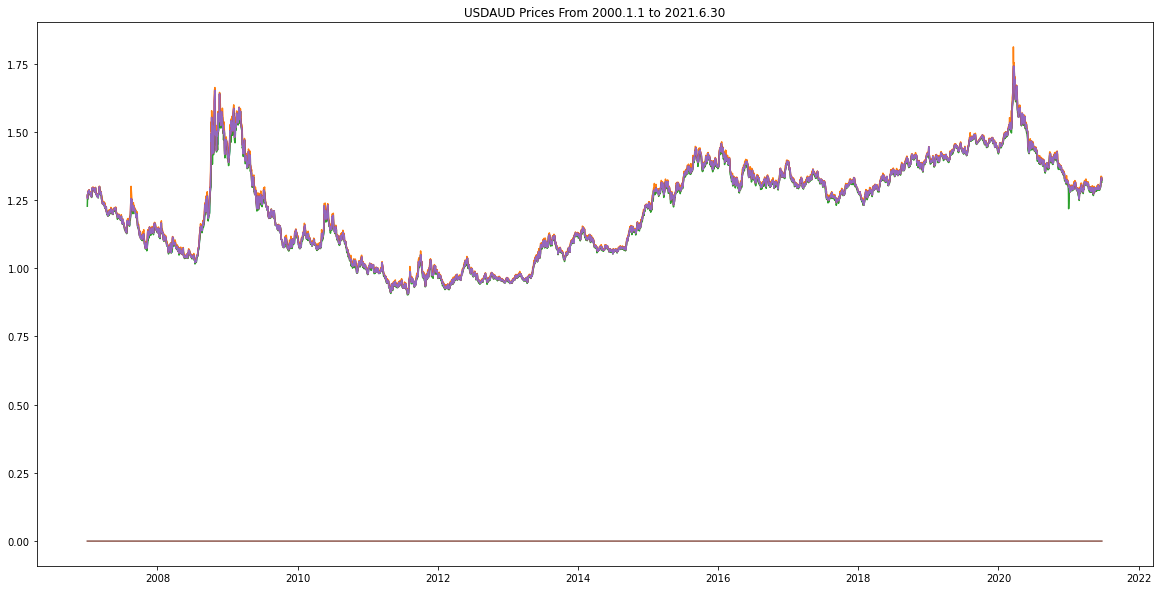

In [ ]:
import pandas_datareader as pdr
from datetime import datetime
from datetime import date
import matplotlib.pyplot as plt
%matplotlib inline

# Define variable for start and end time
# end = datetime.today()
start = date(2007, 1, 1)
end = date(2021, 6, 23)

# data obtained from https://fred.stlouisfed.org/series/DEXUSAL
# AUDUSD = pdr.get_data_fred('DEXUSAL', start, end)     

# data obtained from Yahoo Financials
USDAUD = yf.download('AUD=X', start, end)   
plt.figure(figsize=(20, 10))
plt.plot(USDAUD)
plt.title('USDAUD Prices From 2000.1.1 to 2021.6.30')

In [ ]:
# AUDUSD.tail()

In [ ]:
# AUDUSD.isnull()
USDAUD.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3746 entries, 2007-01-01 to 2021-06-23
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3746 non-null   float64
 1   High       3746 non-null   float64
 2   Low        3746 non-null   float64
 3   Close      3746 non-null   float64
 4   Adj Close  3746 non-null   float64
 5   Volume     3746 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 204.9 KB


In [ ]:
# fill null values with last close
# AUDUSD = AUDUSD.ffill()
# AUDUSD.info()

In [ ]:
# AUDUSD.to_csv('AUDUSD.csv', index=False)
USDAUD.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3746.000000,3746.000000,3746.000000,3746.000000,3746.000000,3746.0
mean,1.219657,1.225908,1.213513,1.219637,1.219637,0.0
std,0.173356,0.175112,0.171690,0.173383,0.173383,0.0
min,0.906210,0.908640,0.902480,0.906210,0.906210,0.0
25%,1.074025,1.078100,1.070000,1.074000,1.074000,0.0
50%,1.251800,1.259800,1.243200,1.251200,1.251200,0.0
75%,1.356275,1.362275,1.350275,1.356200,1.356200,0.0
max,1.740220,1.811594,1.712270,1.741280,1.741280,0.0


In [ ]:
# For yahoo data - drop columns except close
USDAUD.drop(columns=['Open', 'High','Low','Adj Close','Volume'], axis=1, inplace=True)
USDAUD


# Invert exchange rate to conventional quotation method
# AUDUSD=np.power((USDAUD['Close']),-1)
# AUDUSD = AUDUSD.rename(columns = {'': 'Close'}, inplace = False)
# AUDUSD.head()

,Close
Date,
2007-01-01,1.264200
2007-01-02,1.256000
2007-01-03,1.262300
2007-01-04,1.276500
2007-01-05,1.281600
...,...
2021-06-17,1.312900
2021-06-18,1.323294
2021-06-21,1.332623


# Processing cleaned data for Facebook prophet models

In [ ]:
# Renaming initial column names to 'ds'(date) &'y'(target variable)
USDAUD = USDAUD.reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})
USDAUD.head()


,ds,y
0,2007-01-01,1.2642
1,2007-01-02,1.2560
2,2007-01-03,1.2623
3,2007-01-04,1.2765
4,2007-01-05,1.2816


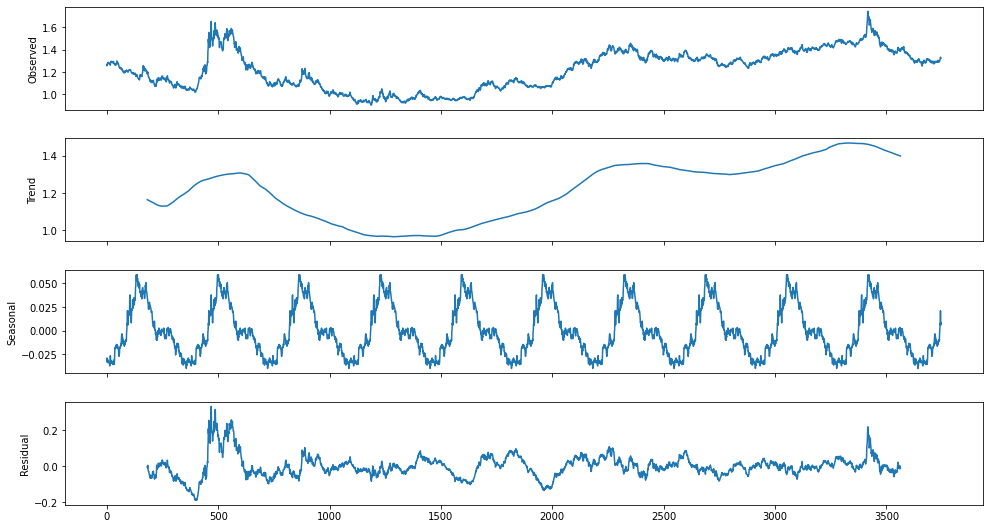

In [ ]:
Y = USDAUD['y']
res = sm.tsa.seasonal_decompose(Y,freq=365)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

We fit the model by instantiating a new Prophet object. Any settings to the forecasting procedure are passed into the constructor. Then you call its fit method and pass in the historical dataframe. Fitting should take 1-5 seconds.  Besides, we should not use weekly seasonality since there is no trading on weekend. We can also define our ‘self_define_cycle’ by add_seasonality function. All the settings can be done with only two lines of code.

In [ ]:
m = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.add_country_holidays(country_name='AU')
# metrics = m.fit(AUDUSD, validate_each_epoch=True, freq="D") 
m.fit(USDAUD)

Predictions are then made on a dataframe with a column ds containing the dates for which a prediction is to be made. You can get a suitable dataframe that extends into the future a specified number of days using the helper method Prophet.make_future_dataframe. By default it will also include the dates from the history, so we will see the model fit as well.

In [ ]:
#predicting for the next 100 days from 2021.6.18
future = m.make_future_dataframe(periods=7, include_history=True)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head

<bound method NDFrame.head of              ds      yhat  yhat_lower  yhat_upper
0    2007-01-01  1.281477    1.216176    1.344799
1    2007-01-02  1.283777    1.221438    1.349291
2    2007-01-03  1.282654    1.217438    1.352113
3    2007-01-04  1.281345    1.215000    1.347694
4    2007-01-05  1.280589    1.214572    1.347811
...         ...       ...         ...         ...
3748 2021-06-26  1.386827    1.322964    1.453299
3749 2021-06-27  1.385775    1.321458    1.453387
3750 2021-06-28  1.385673    1.321887    1.449394
3751 2021-06-29  1.386855    1.319708    1.454543
3752 2021-06-30  1.388449    1.322223    1.456356

[3753 rows x 4 columns]>

In [ ]:
# chart that is not interactive
# fig, ax = plt.subplots(figsize=(20, 10)) # change figsize(x,y) to shrink or enlarge chart
# m.plot(forecast, xlabel="Date", ylabel="AUDUSD Price", ax=ax)
# ax.xaxis.label.set_size(28)
# ax.yaxis.label.set_size(28)
# ax.tick_params(axis='both', which='major', labelsize=24)
# ax.set_title("AUDUSD Daily Exchange Rate Chart", fontsize=28, fontweight="bold") 

In [ ]:
# interactive chart by plotly
plot_plotly(m, forecast, xlabel='Date', ylabel='USDAUD Price', figsize=(1500,1000))

In [ ]:
plot_components_plotly(m, forecast,  figsize=(1500,1000))

In [ ]:
# plotting loss
# fig, ax = plt.subplots(figsize=(14, 10))
# ax.plot(metrics["MAE"], '-b', linewidth=6, label="Training Loss")  
# ax.plot(metrics["MAE_val"], '-r', linewidth=2, label="Validation Loss")
# ax.legend(loc='center right', fontsize=16)
# ax.tick_params(axis='both', which='major', labelsize=20)
# ax.set_xlabel("Epoch", fontsize=28, fontweight="bold")
# ax.set_ylabel("Loss", fontsize=28, fontweight="bold")
# ax.set_title("Model Loss (MAE)", fontsize=28, fontweight="bold") 

# NeuralProphet
A Neural Network based Time-Series model, inspired by Facebook Prophet and AR-Net(A simple auto-regressive Neural Network for time-series ), built on PyTorch.

Trend
With NeuralProphet, we can model trends in time-series data by specifying a few arguments. NeuralProphet allows us to specify the following parameters in the fit method when modeling trends:
n_changepoints — specifies the number of points where the broader trend (rate of increase/decrease) in the data changes.

trend_reg — a regularization parameter that controls the flexibility of changepoint selection. Larger values (~1–100) will limit the variability of changepoints. Smaller values (~0.001–1.0) will allow for more variability in changepoints.

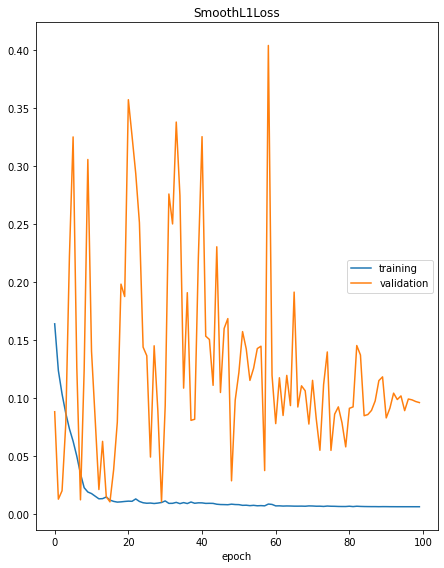

Epoch[100/100]: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s, SmoothL1Loss=0.0062, MAE=0.0454, RegLoss=0.00469, MAE_val=0.243, SmoothL1Loss_val=0.096]


In [ ]:

model = NeuralProphet(n_changepoints=100,
                      trend_reg=0.05,
                      yearly_seasonality=False,
                      weekly_seasonality=False,
                      daily_seasonality=False)

# with cross-validation
# validation proportion of data (20%)

metrics = model.fit(USDAUD, validate_each_epoch=True, 
                    valid_p=0.2, freq='D', 
                    plot_live_loss=True, 
                    epochs=100)

# To check all arguments use:
# help(NeuralProphet)

In [ ]:
def plot_forecast(model, data, periods, historic_pred=True, highlight_steps_ahead=None):
    
    future = model.make_future_dataframe(data, 
                                         periods=periods, 
                                         n_historic_predictions=historic_pred)
    forecast = model.predict(future)
    
    if highlight_steps_ahead is not None:
        model = model.highlight_nth_step_ahead_of_each_forecast(highlight_steps_ahead)
        model.plot_last_forecast(forecast)
    else:    
        fig, ax = plt.subplots(figsize=(20, 10))
        model.plot(forecast, xlabel="Date", ylabel="USDAUD Prices", ax=ax)
        ax.set_title("USDAUD Actual & Predicted Prices", fontsize=28, fontweight="bold")





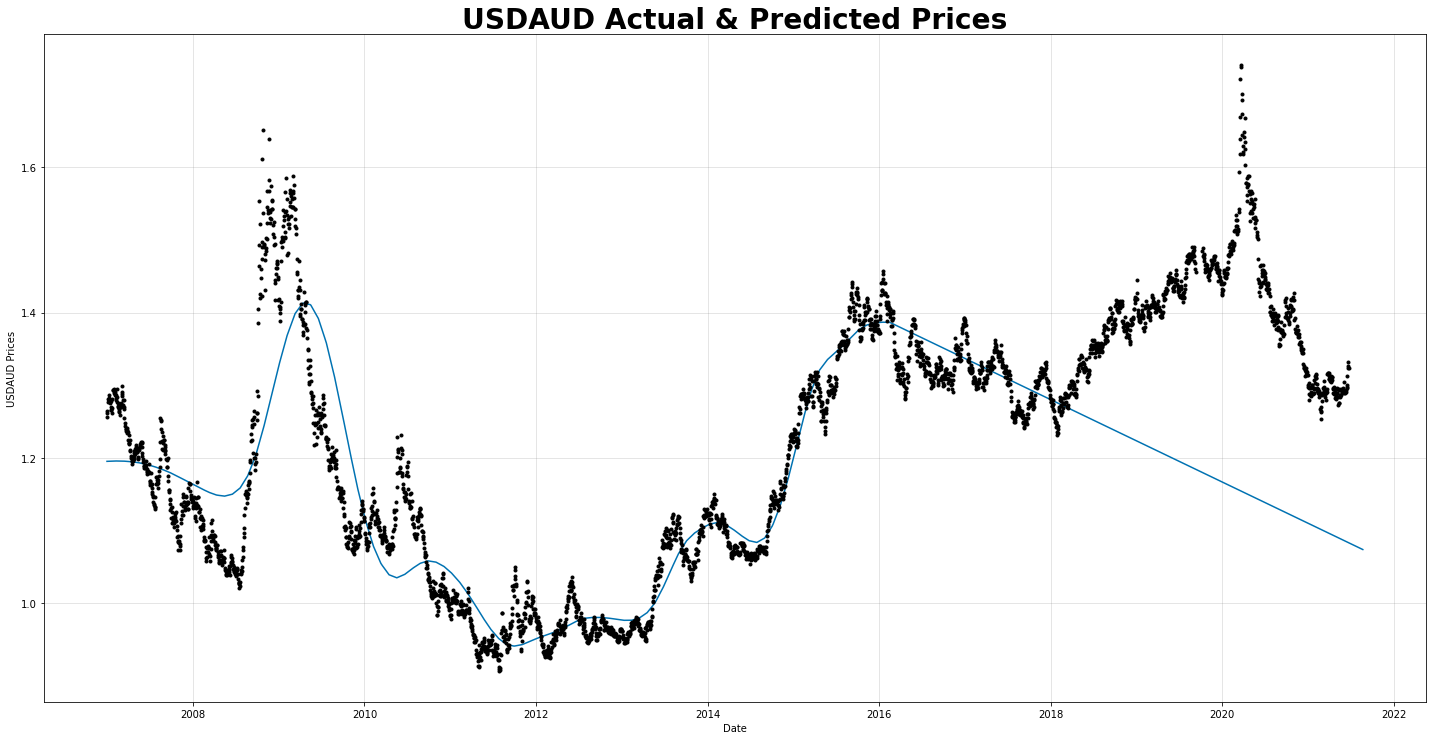

In [ ]:
plot_forecast(model, USDAUD, periods=60)

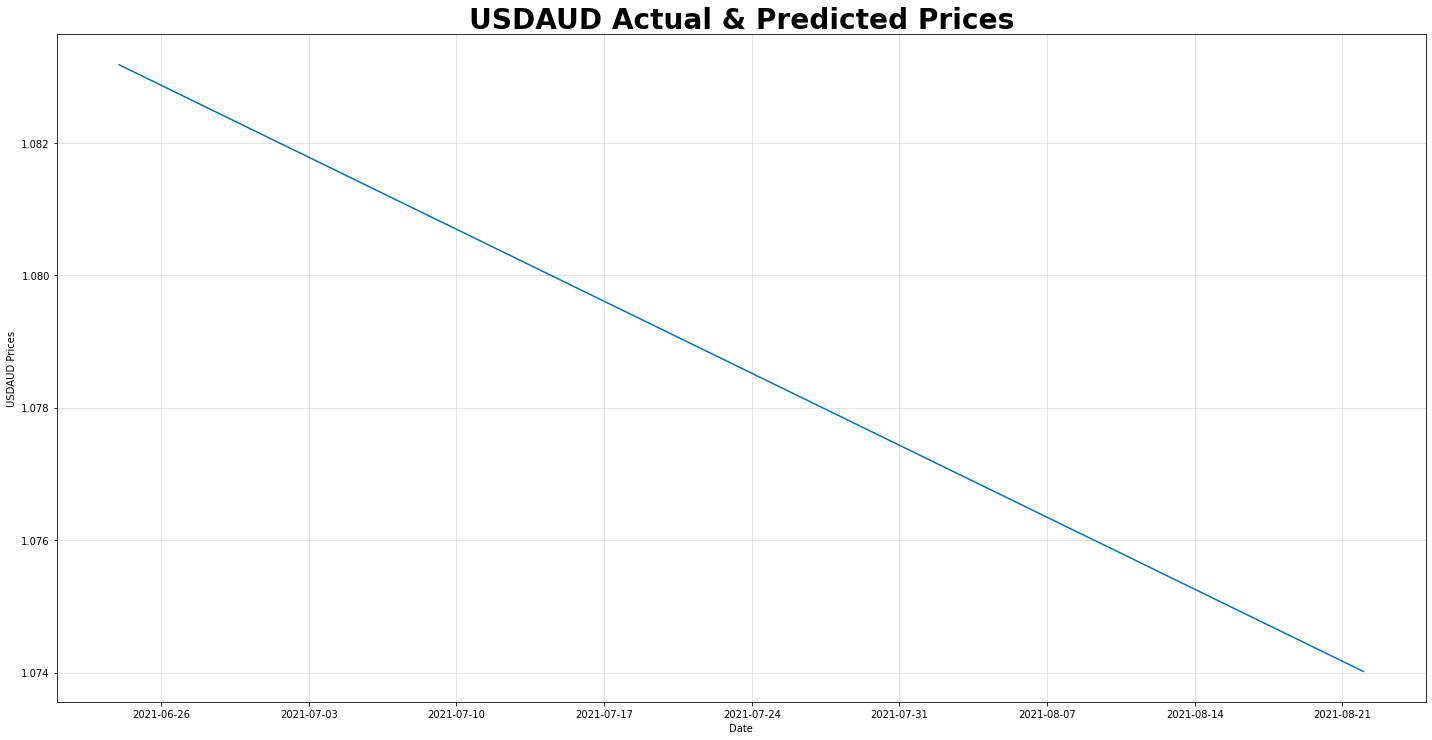

In [ ]:
plot_forecast(model, USDAUD, periods=60, historic_pred=False)

## Seasonality

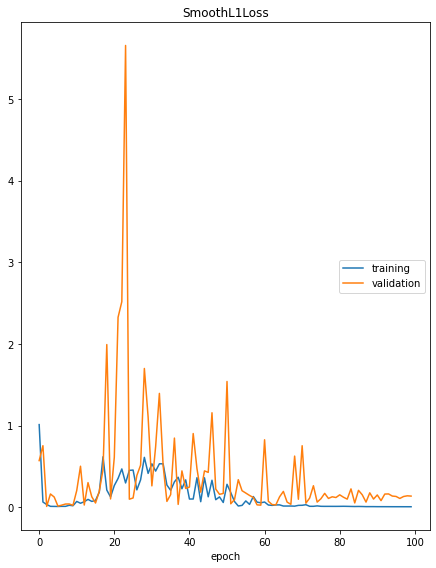

Epoch[100/100]: 100%|██████████| 100/100 [00:22<00:00,  4.43it/s, SmoothL1Loss=0.00809, MAE=0.0518, RegLoss=0.0174, MAE_val=0.295, SmoothL1Loss_val=0.138]


In [ ]:
model = NeuralProphet(n_changepoints=100,
                      trend_reg=0.5,
                      yearly_seasonality=True,
                      weekly_seasonality=True,
                      daily_seasonality=True)

metrics = model.fit(USDAUD, validate_each_epoch=True, 
                    valid_p=0.2, freq='D', 
                    plot_live_loss=True, 
                    epochs=100)

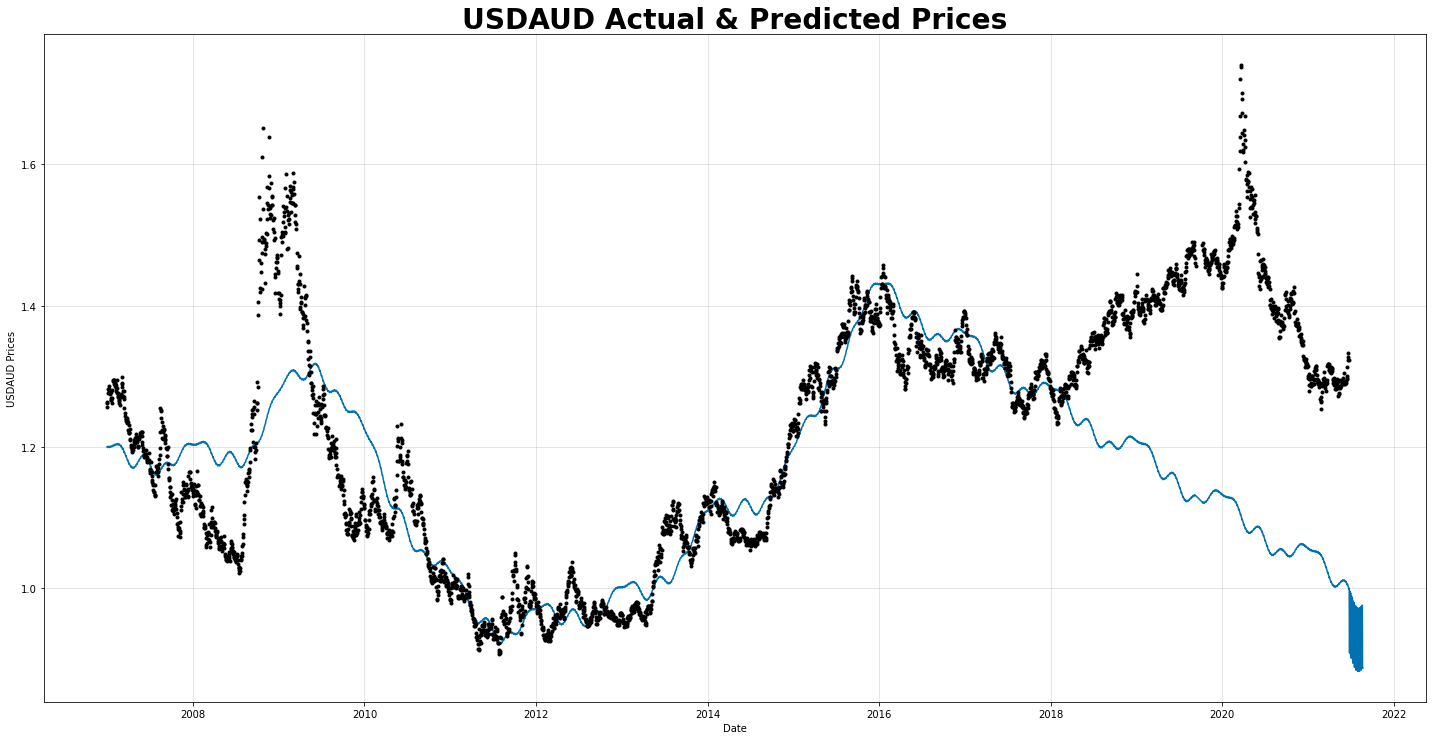

In [ ]:
plot_forecast(model, USDAUD, periods=60, historic_pred=True)

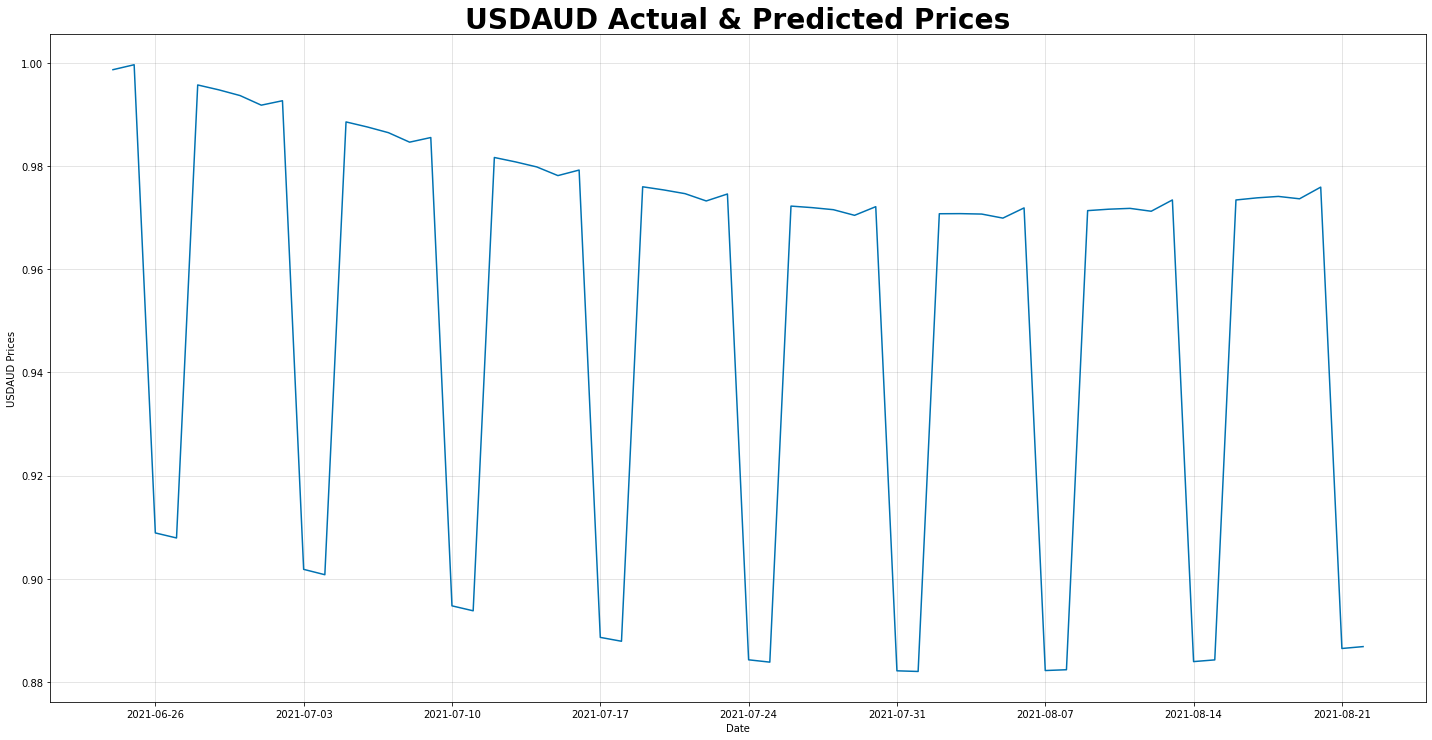

In [ ]:
plot_forecast(model, USDAUD, periods=60, historic_pred=False)

## Using AR-Net
AR-Net is an autoregressive neural network used for time-series forecasting. Autoregressive models use past historical data from previous timesteps to generate predictions for the next timesteps. The values of the target variable in previous timesteps are parameters that serve as inputs for the models. This is where the term autoregressive comes from.  

We can train a model that uses the price of the AUDUSD from the past 60 days to predict the price for the next 60 days. These parameters are specified by the n_lags and n_forecasts arguments in the code below.

After all the tedious preprocessing, we get to train the model. We create a new untrained instance of our neuralprophet model and use the fit() method to train the model. The final model will be stored in the variable ‘model’

In [ ]:
# To check all arguments use:

help(NeuralProphet)

Help on class NeuralProphet in module neuralprophet.forecaster:

class NeuralProphet(builtins.object)
 |  NeuralProphet(growth='linear', changepoints=None, n_changepoints=5, changepoints_range=0.8, trend_reg=0, trend_reg_threshold=False, yearly_seasonality='auto', weekly_seasonality='auto', daily_seasonality='auto', seasonality_mode='additive', seasonality_reg=0, n_forecasts=1, n_lags=0, num_hidden_layers=0, d_hidden=None, ar_sparsity=None, learning_rate=None, epochs=None, batch_size=None, loss_func='Huber', train_speed=None, normalize='auto', impute_missing=True, log_level=None)
 |  
 |  NeuralProphet forecaster.
 |  
 |  A simple yet powerful forecaster that models:
 |  Trend, seasonality, events, holidays, auto-regression, lagged covariates, and future-known regressors.
 |  Can be regualrized and configured to model nonlinear relationships.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, growth='linear', changepoints=None, n_changepoints=5, changepoints_range=0.8, trend_reg=0

In [ ]:
model = NeuralProphet(
    n_forecasts=7,
    n_lags=100,
    changepoints_range=0.95,
    n_changepoints=100,
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    batch_size=64,
    epochs=100,
    learning_rate=1.0, 
)

model = model.add_country_holidays("AU", mode="additive", lower_window=-1, upper_window=1)

# Exclude weekends
USDAUD = USDAUD[USDAUD['ds'].dt.dayofweek < 5]

# fit the model using all data
# model.fit(USDAUD, freq="D")  

# with cross validation 20%, or train-test split 80-20
model.fit(USDAUD, freq='D', valid_p=0.2, epochs=100)

INFO: nprophet - _handle_missing_data: 1542 missing dates were added.
INFO:nprophet:1542 missing dates were added.
INFO: nprophet - _handle_missing_data: 1542 NaN values in column y were auto-imputed.
INFO:nprophet:1542 NaN values in column y were auto-imputed.
Epoch[100/100]: 100%|██████████| 100/100 [00:26<00:00,  3.75it/s, SmoothL1Loss=0.000427, MAE=0.0129, RegLoss=0]


,SmoothL1Loss,MAE,RegLoss
0,0.123019,0.232418,0.0
1,0.003480,0.039729,0.0
2,0.001379,0.025190,0.0
3,0.001223,0.023982,0.0
4,0.002424,0.033779,0.0
...,...,...,...
95,0.000456,0.013535,0.0
96,0.000436,0.013101,0.0
97,0.000432,0.013016,0.0
98,0.000429,0.012968,0.0


INFO: nprophet - _handle_missing_data: 1542 missing dates were added.
INFO:nprophet:1542 missing dates were added.
INFO: nprophet - _handle_missing_data: 1542 NaN values in column y were auto-imputed.
INFO:nprophet:1542 NaN values in column y were auto-imputed.


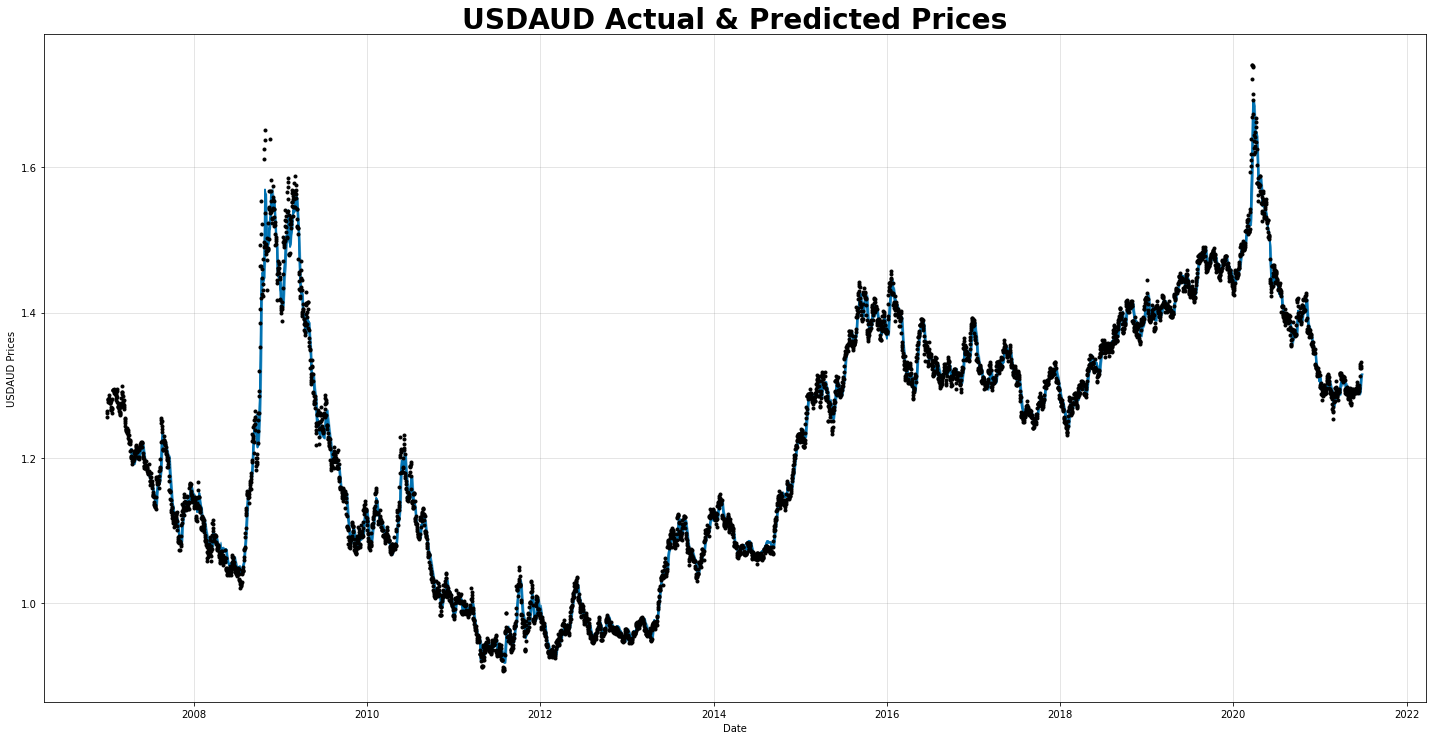

In [ ]:
plot_forecast(model, USDAUD, periods=7, historic_pred=True)

In [ ]:
future = model.make_future_dataframe(USDAUD, periods=7)
forecast = m.predict(future)
forecast.tail(7)

INFO: nprophet - _handle_missing_data: 40 missing dates were added.
INFO:nprophet:40 missing dates were added.
INFO: nprophet - _handle_missing_data: 40 NaN values in column y were auto-imputed.
INFO:nprophet:40 NaN values in column y were auto-imputed.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Anzac Day,Anzac Day_lower,Anzac Day_upper,Australia Day,Australia Day_lower,Australia Day_upper,Australia Day (Observed),Australia Day (Observed)_lower,Australia Day (Observed)_upper,Boxing Day,Boxing Day_lower,Boxing Day_upper,Boxing Day (Observed),Boxing Day (Observed)_lower,Boxing Day (Observed)_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),Christmas Day (Observed)_lower,Christmas Day (Observed)_upper,Easter Monday,Easter Monday_lower,Easter Monday_upper,Good Friday,Good Friday_lower,Good Friday_upper,New Year's Day,New Year's Day_lower,New Year's Day_upper,New Year's Day (Observed),New Year's Day (Observed)_lower,New Year's Day (Observed)_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,holidays_lower,holidays_upper,monthly,monthly_lower,monthly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
140,2021-06-24,1.386655,1.322219,1.454486,1.386655,1.386655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000838,0.000838,0.000838,0.0,0.0,0.0,0.000838,0.000838,0.000838,0.0,0.0,0.0,1.387493
141,2021-06-25,1.386625,1.324513,1.452473,1.386625,1.386625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001061,0.001061,0.001061,0.0,0.0,0.0,0.001061,0.001061,0.001061,0.0,0.0,0.0,1.387686
142,2021-06-26,1.386595,1.323537,1.451050,1.386595,1.386595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000232,0.000232,0.000232,0.0,0.0,0.0,0.000232,0.000232,0.000232,0.0,0.0,0.0,1.386827
143,2021-06-27,1.386565,1.323124,1.453638,1.386565,1.386565,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000790,-0.000790,-0.000790,0.0,0.0,0.0,-0.000790,-0.000790,-0.000790,0.0,0.0,0.0,1.385775
144,2021-06-28,1.386535,1.316142,1.454059,1.386535,1.386535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000862,-0.000862,-0.000862,0.0,0.0,0.0,-0.000862,-0.000862,-0.000862,0.0,0.0,0.0,1.385673
145,2021-06-29,1.386505,1.317939,1.450298,1.386505,1.386505,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000350,0.000350,0.000350,0.0,0.0,0.0,0.000350,0.000350,0.000350,0.0,0.0,0.0,1.386855
146,2021-06-30,1.386475,1.320570,1.449234,1.386475,1.386475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001974,0.001974,0.001974,0.0,0.0,0.0,0.001974,0.001974,0.001974,0.0,0.0,0.0,1.388449


In [ ]:
forecast = forecast[['ds', 'trend','yhat_lower','yhat_upper']].copy()
forecast = forecast.iloc[-7:]
# forecast = forecast.drop(142,143)
print(forecast)

            ds     trend  yhat_lower  yhat_upper
140 2021-06-24  1.386655    1.322219    1.454486
141 2021-06-25  1.386625    1.324513    1.452473
142 2021-06-26  1.386595    1.323537    1.451050
143 2021-06-27  1.386565    1.323124    1.453638
144 2021-06-28  1.386535    1.316142    1.454059
145 2021-06-29  1.386505    1.317939    1.450298
146 2021-06-30  1.386475    1.320570    1.449234


In [ ]:
forecast.to_csv('USDAUD-forecast.csv', index=False)

In [ ]:
start = date(2021, 6, 24)
end = date(2021, 6, 30)
USDAUD = yf.download('AUD=X', start, end)   
USDAUD.drop(columns=['Open','Adj Close','Volume'], axis=1, inplace=True)
USDAUD.head()

[*********************100%***********************]  1 of 1 completed


,High,Low,Close
Date,,,
2021-06-24,1.321320,1.317000,1.320230
2021-06-25,1.319090,1.312500,1.318900
2021-06-28,1.323469,1.315097,1.316656
2021-06-29,1.331820,1.320800,1.321283
2021-06-30,1.334610,1.328198,1.330920


In [ ]:
USDAUD.to_csv('USDAUD-actual.csv', index=False)
# combine 2 datframes
# result = forecast.join(USDAUD)
# print(result)

In [ ]:
# interactive chart by plotly
# plot_plotly(model, forecast, xlabel='Date', ylabel='AUDUSD Price', figsize=(1500,1000))

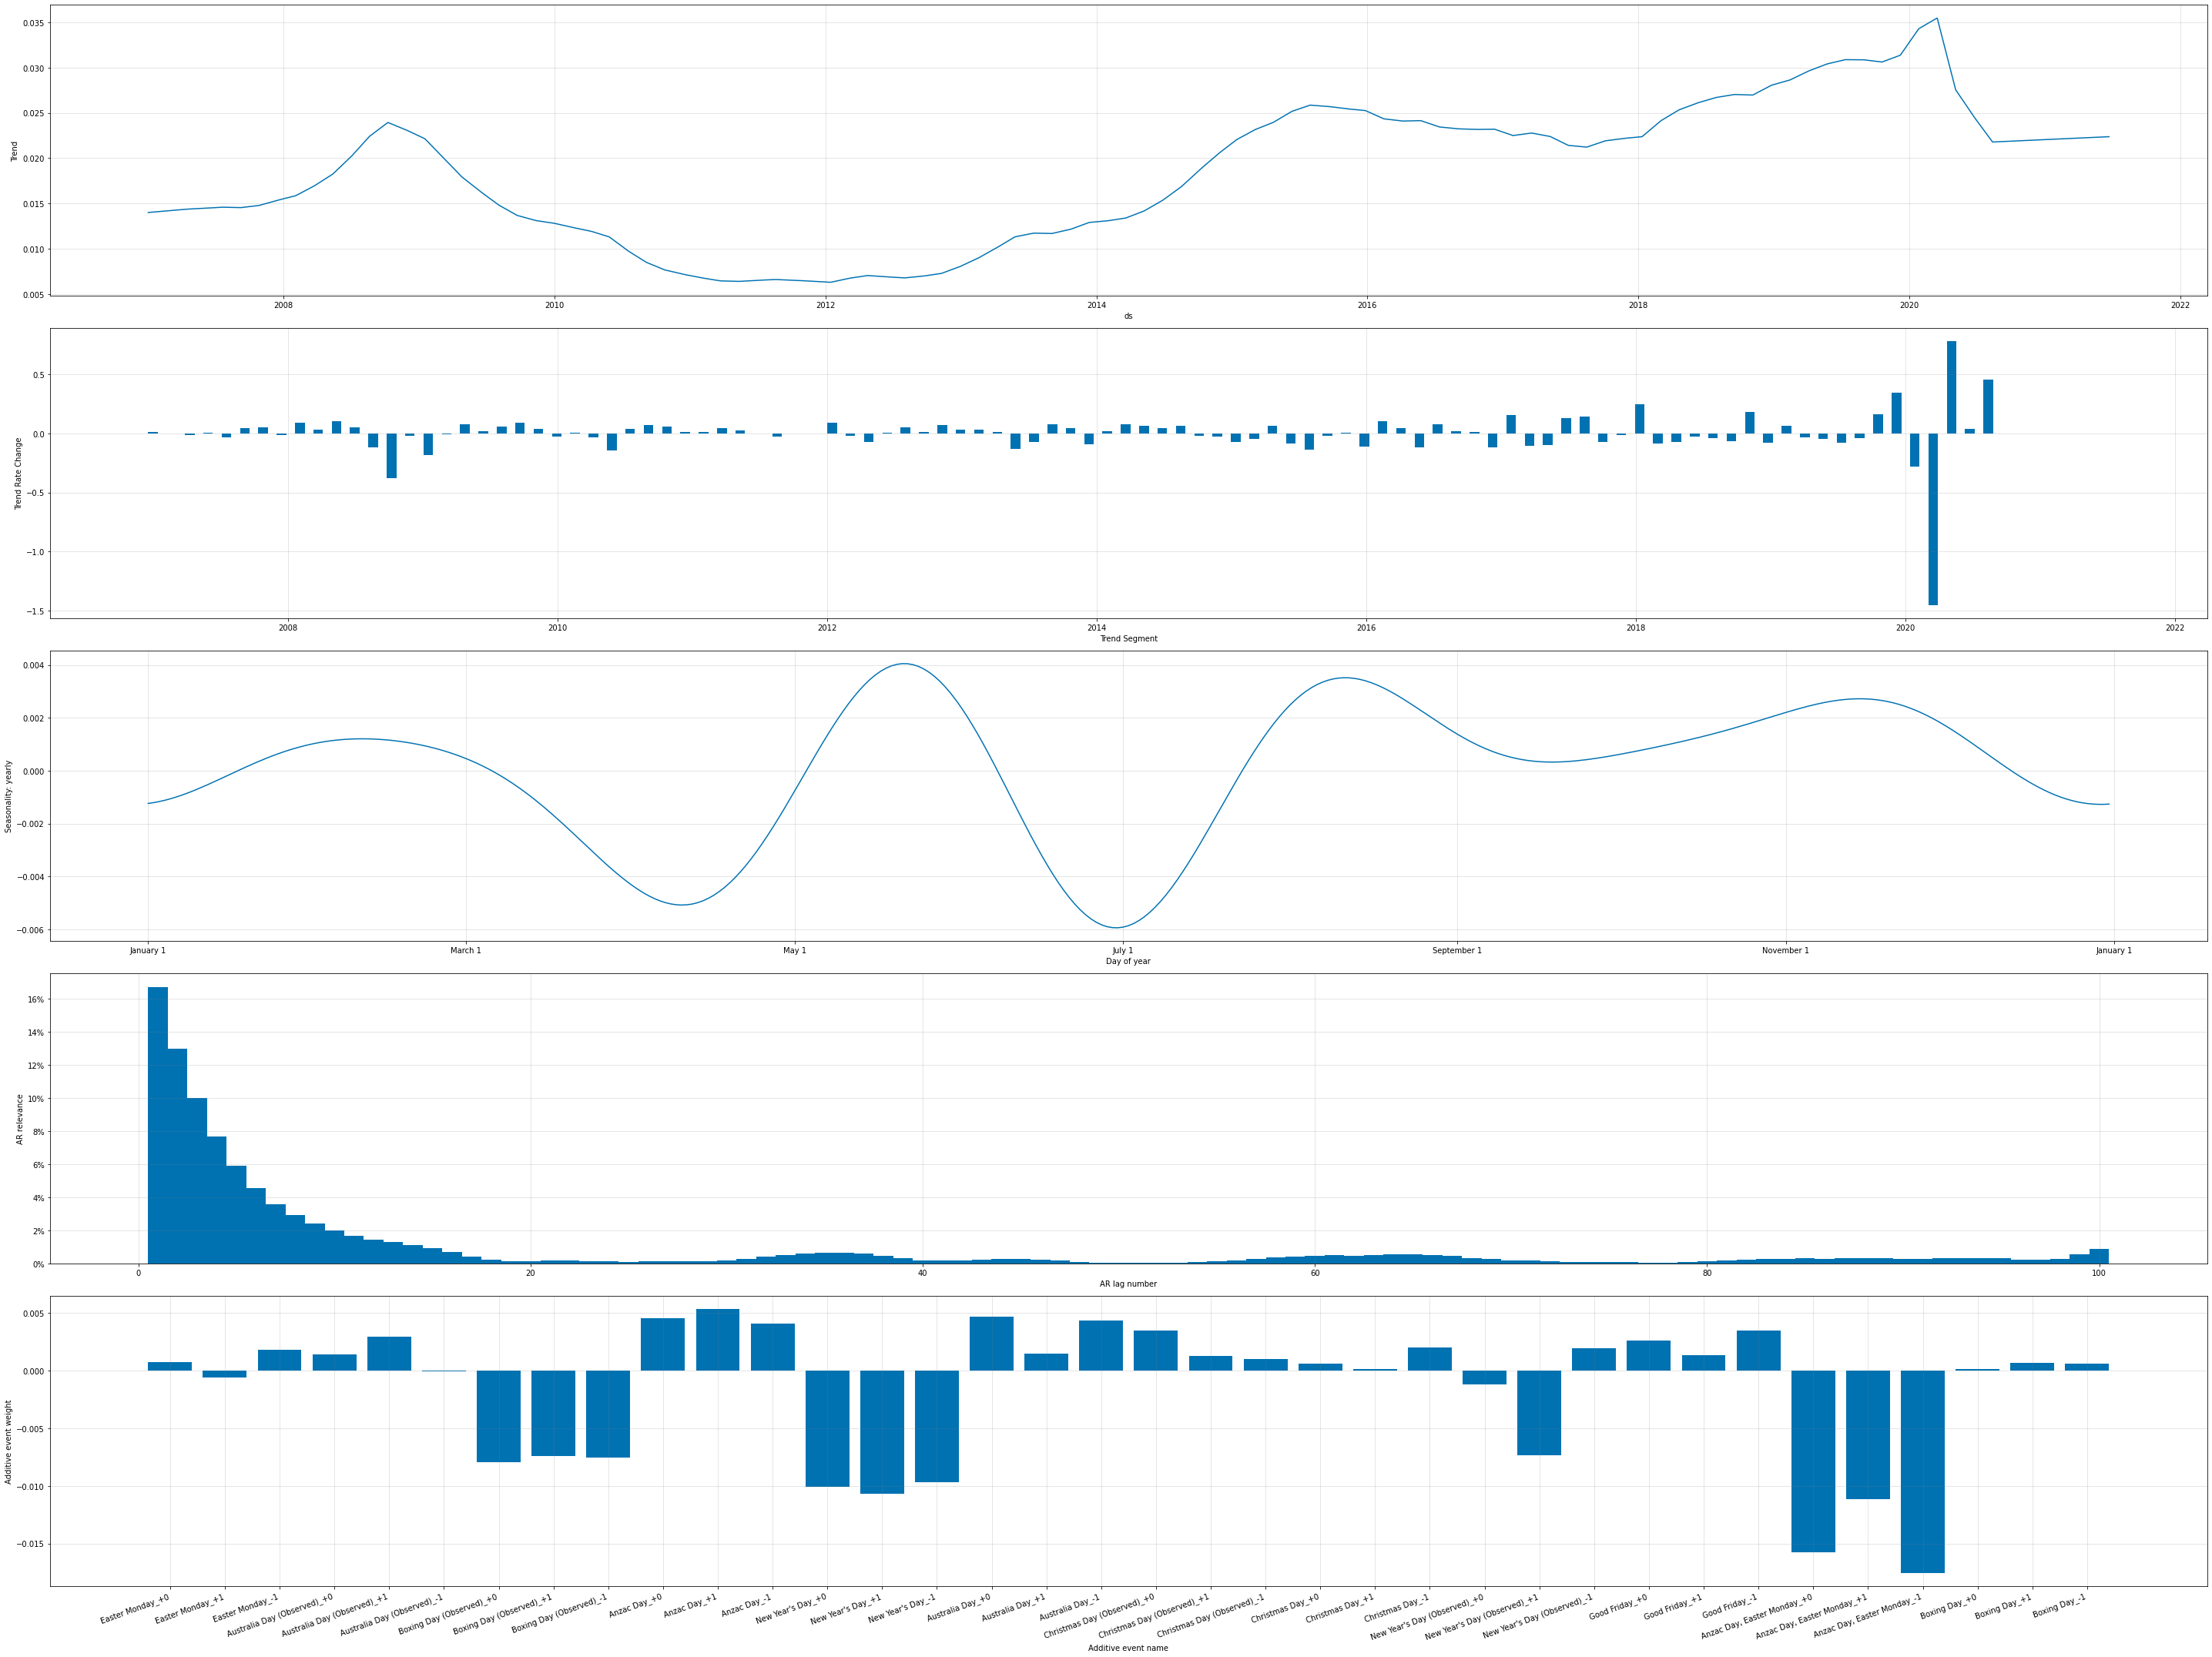

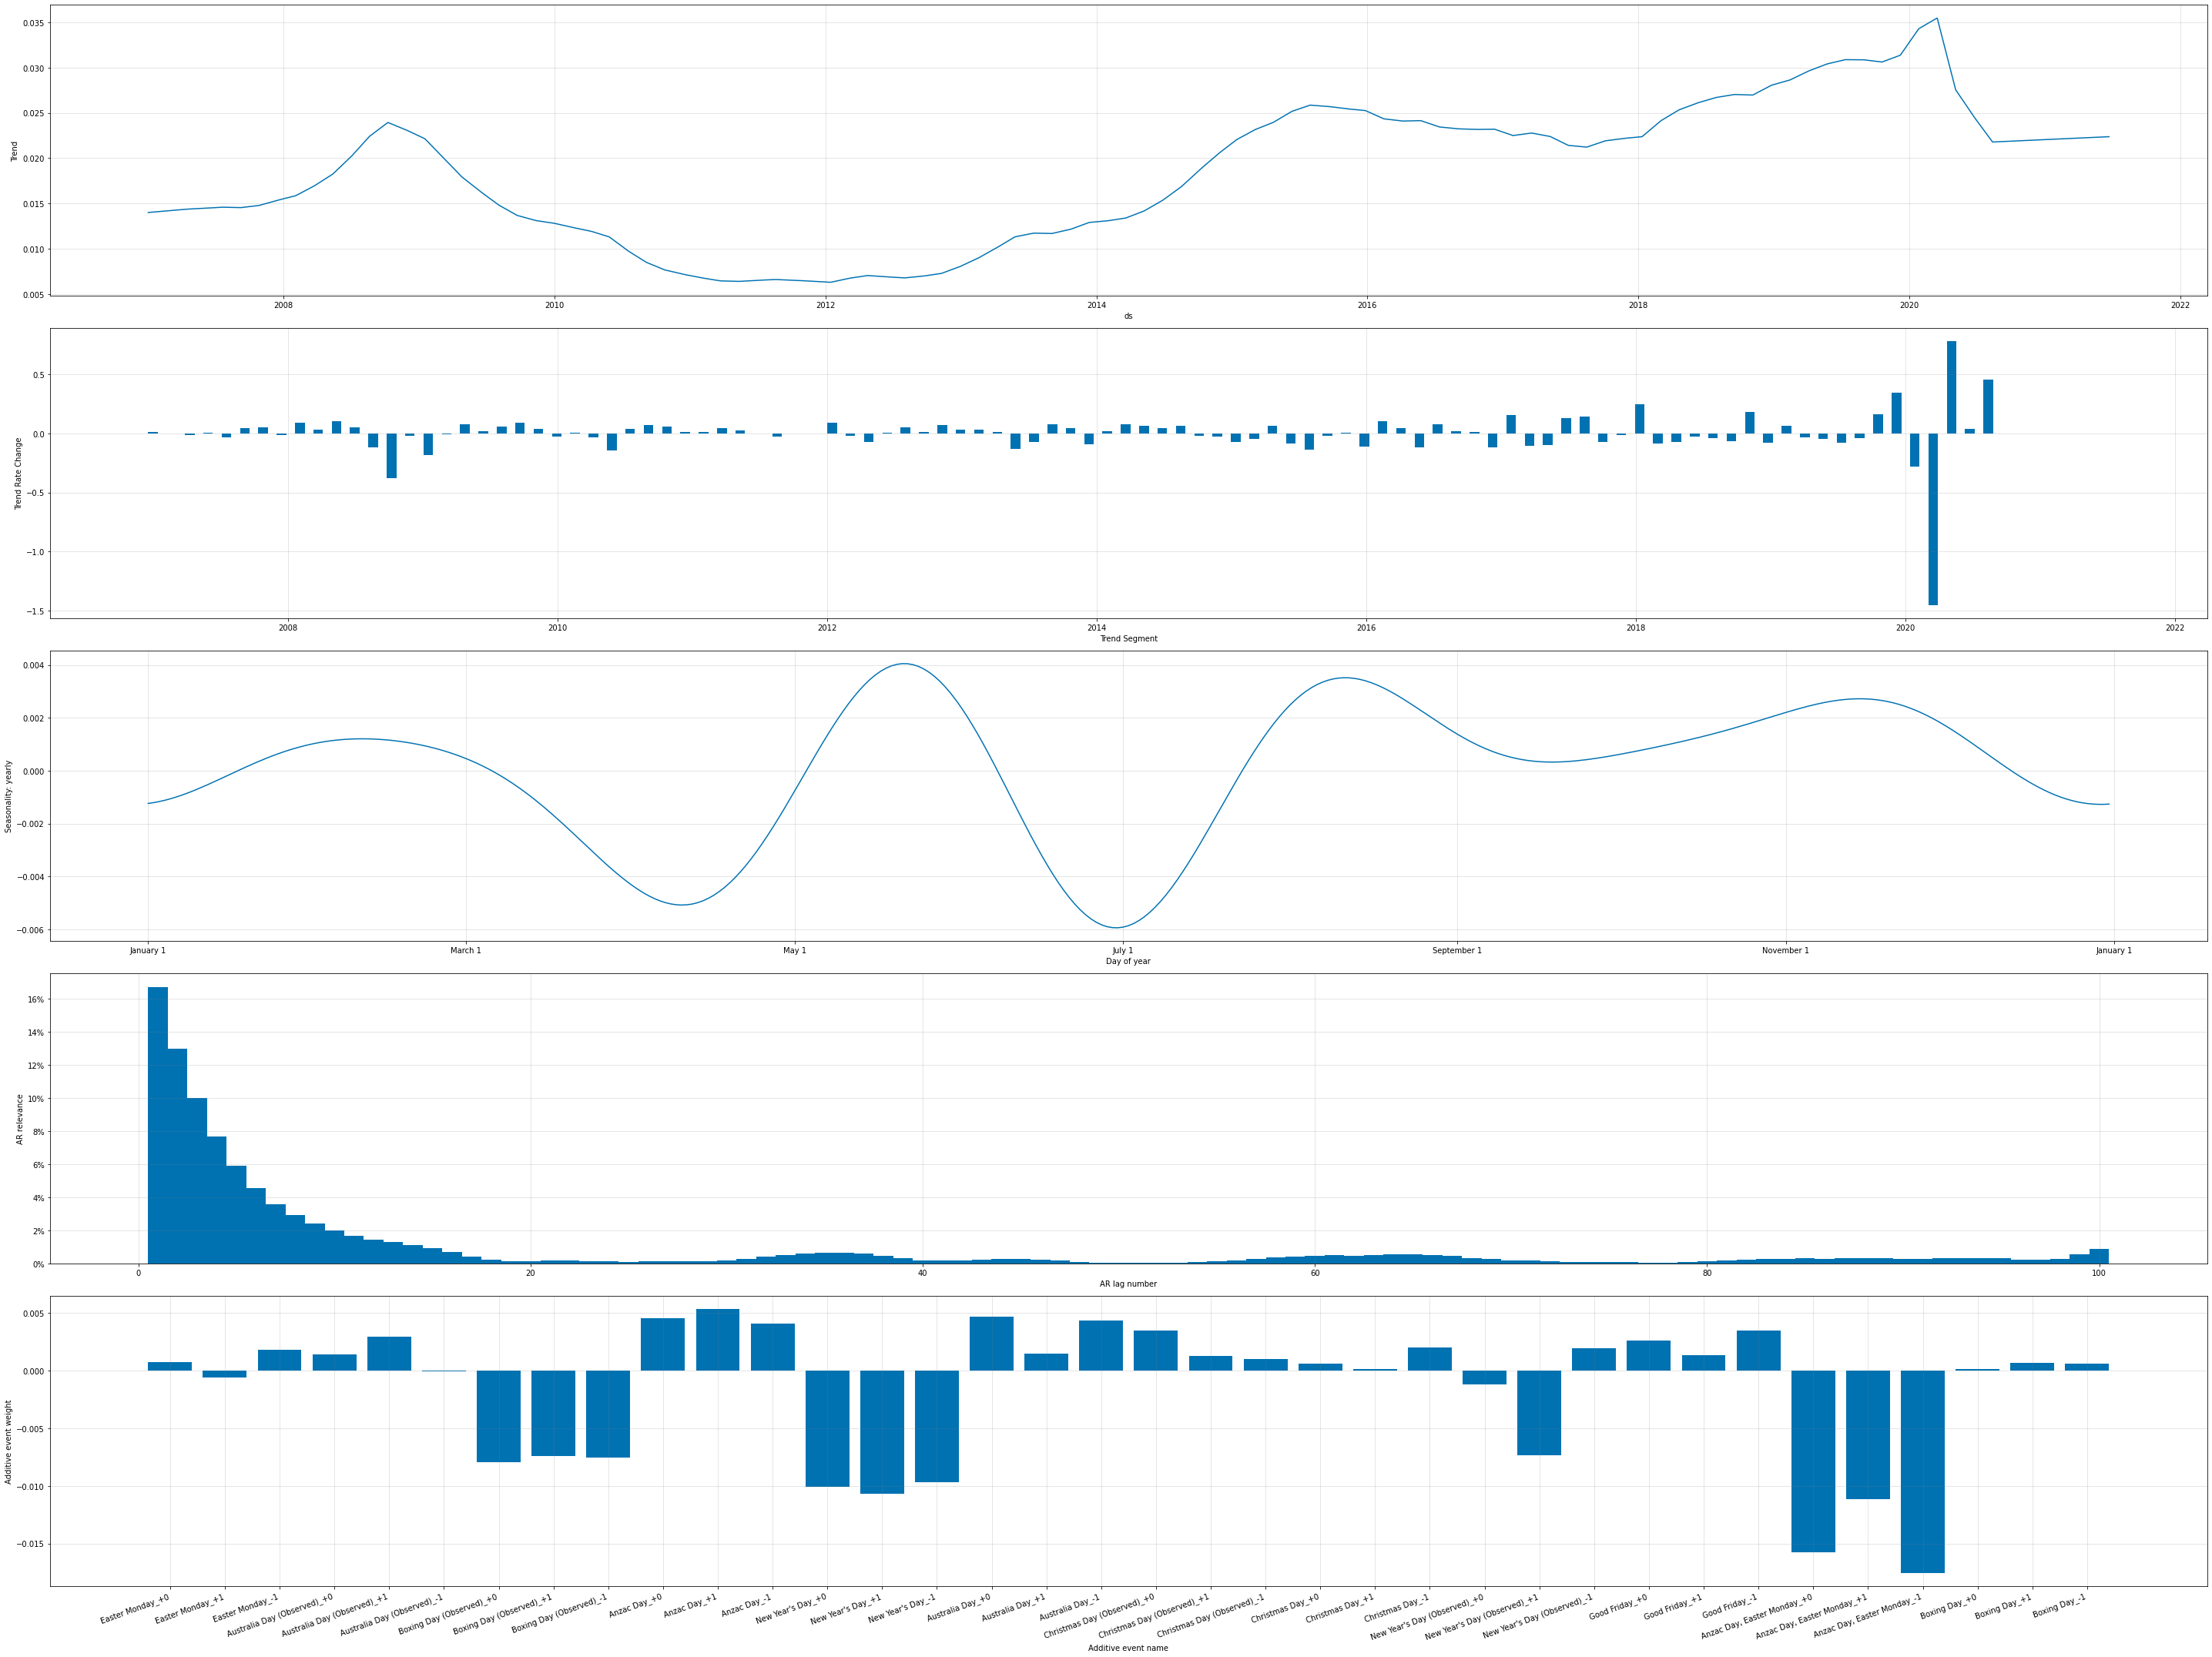

In [ ]:
model.plot_parameters(figsize=(40, 30))